In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [ ]:
import pandas as pd
df = pd.read_json("/content/drive/MyDrive/Books_5.json", lines=True, nrows=10000)

df.shape

(10000, 9)

In [ ]:
!pip install transformers
!pip install torch
!pip install pandas

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.9 MB/s eta 0:00:00


In [ ]:
threshold = 3.5

# Transform the 'overall' column to binary values (1 or 0)
df['target'] = (df['overall'] >= threshold).astype(int)


In [ ]:
!pip install tqdm

# **BERT**

## BERT MultiClass

In [ ]:
# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviewText'], df['overall'], test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)


# Convert the lists to tensors, adjusting labels to match expected range
train_labels = torch.tensor(train_labels.tolist()) - 1
val_labels = torch.tensor(val_labels.tolist()) - 1


# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            val_labels)

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

from tqdm import tqdm

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar_train.set_postfix(train_loss=total_train_loss / len(progress_bar_train))

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_val:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

        progress_bar_val.set_postfix(val_loss=total_val_loss / len(progress_bar_val))

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')

# Save the model
model.save_pretrained('./bert_model_sentiment_analysis')
tokenizer.save_pretrained('./bert_model_sentiment_analysis')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 25/25 [00:05<00:00,  4.29batch/s, val_loss=0.955]


Epoch 1:
  Train Loss: 0.9582
  Validation Loss: 0.9547


Epoch 2/5: 100%|██████████| 25/25 [00:06<00:00,  4.02batch/s, val_loss=0.905]


Epoch 2:
  Train Loss: 0.7379
  Validation Loss: 0.9053


Epoch 3/5: 100%|██████████| 25/25 [00:06<00:00,  4.03batch/s, val_loss=0.844]


Epoch 3:
  Train Loss: 0.5500
  Validation Loss: 0.8436


Epoch 4/5: 100%|██████████| 25/25 [00:06<00:00,  3.97batch/s, val_loss=1.01]


Epoch 4:
  Train Loss: 0.4231
  Validation Loss: 1.0115


Epoch 5/5: 100%|██████████| 25/25 [00:06<00:00,  4.00batch/s, val_loss=0.963]


Epoch 5:
  Train Loss: 0.3003
  Validation Loss: 0.9632


('./bert_model_sentiment_analysis/tokenizer_config.json',
 './bert_model_sentiment_analysis/special_tokens_map.json',
 './bert_model_sentiment_analysis/vocab.txt',
 './bert_model_sentiment_analysis/added_tokens.json')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define lists to store predictions and true labels
all_val_preds = []
all_val_true = []

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_val_preds.extend(preds.cpu().numpy())
        all_val_true.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_val_true, all_val_preds)
precision = precision_score(all_val_true, all_val_preds, average='weighted')
recall = recall_score(all_val_true, all_val_preds, average='weighted')
f1 = f1_score(all_val_true, all_val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-score: {f1:.4f}')


Validation Accuracy: 0.6850
Validation Precision: 0.6669
Validation Recall: 0.6850
Validation F1-score: 0.6757


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BERT Binary Classification

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Assuming you've already loaded the data into a DataFrame named df

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviewText'], df['target'], test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Convert the lists to tensors, adjusting labels to binary
train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            val_labels)

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 2

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar.set_postfix(train_loss=total_train_loss / len(progress_bar))

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            progress_bar.set_postfix(val_loss=total_val_loss / len(progress_bar))

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/2: 100%|██████████| 25/25 [00:06<00:00,  3.64batch/s, val_loss=0.262]


Epoch 1:
  Train Loss: 0.3660


Epoch 2/2: 100%|██████████| 25/25 [00:07<00:00,  3.57batch/s, val_loss=0.356]

Epoch 2:
  Train Loss: 0.2252


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define lists to store predictions and true labels
all_val_preds = []
all_val_true = []

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Compute probabilities
        preds = torch.argmax(probs, dim=1)

        all_val_preds.extend(preds.cpu().numpy())
        all_val_true.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_val_true, all_val_preds)
precision = precision_score(all_val_true, all_val_preds)
recall = recall_score(all_val_true, all_val_preds)
f1 = f1_score(all_val_true, all_val_preds)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-score: {f1:.4f}')


Validation Accuracy: 0.9000
Validation Precision: 0.9255
Validation Recall: 0.9490
Validation F1-score: 0.9371


# **DistilBERT**

## DistilBERT Binary Classification

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviewText'], df['target'], test_size=0.2, random_state=42)

# Load the pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Convert the lists to tensors, adjusting labels to binary
train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            val_labels)

# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 4

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar.set_postfix(train_loss=total_train_loss / len(progress_bar))

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation loop
    model.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            progress_bar.set_postfix(val_loss=total_val_loss / len(progress_bar))

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/4: 100%|██████████| 25/25 [00:03<00:00,  6.75batch/s, val_loss=0.282]


Epoch 1:
  Train Loss: 0.3664


Epoch 2/4: 100%|██████████| 25/25 [00:03<00:00,  6.84batch/s, val_loss=0.303]


Epoch 2:
  Train Loss: 0.1759


Epoch 3/4: 100%|██████████| 25/25 [00:03<00:00,  6.73batch/s, val_loss=0.508]


Epoch 3:
  Train Loss: 0.0795


Epoch 4/4: 100%|██████████| 25/25 [00:03<00:00,  6.85batch/s, val_loss=0.404]

Epoch 4:
  Train Loss: 0.0307


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define lists to store predictions and true labels
all_val_preds = []
all_val_true = []

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Compute probabilities
        preds = torch.argmax(probs, dim=1)

        all_val_preds.extend(preds.cpu().numpy())
        all_val_true.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_val_true, all_val_preds)
precision = precision_score(all_val_true, all_val_preds)
recall = recall_score(all_val_true, all_val_preds)
f1 = f1_score(all_val_true, all_val_preds)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-score: {f1:.4f}')


Validation Accuracy: 0.9150
Validation Precision: 0.9487
Validation Recall: 0.9427
Validation F1-score: 0.9457


## DistilBERT MultiClass (1 to 5)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviewText'], df['overall'], test_size=0.2, random_state=42)

# Load the pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

# Convert the lists to tensors, adjusting labels to match expected range
train_labels = torch.tensor(train_labels.tolist()) - 1
val_labels = torch.tensor(val_labels.tolist()) - 1

# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            val_labels)

# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_train:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar_train.set_postfix(train_loss=total_train_loss / len(progress_bar_train))

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_val:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

        progress_bar_val.set_postfix(val_loss=total_val_loss / len(progress_bar_val))

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 250/250 [00:31<00:00,  7.88batch/s, val_loss=0.825]


Epoch 1:
  Train Loss: 0.9626
  Validation Loss: 0.8247


Epoch 2/5: 100%|██████████| 250/250 [00:31<00:00,  7.87batch/s, val_loss=0.814]


Epoch 2:
  Train Loss: 0.7239
  Validation Loss: 0.8136


Epoch 3/5: 100%|██████████| 250/250 [00:31<00:00,  7.88batch/s, val_loss=0.88]


Epoch 3:
  Train Loss: 0.5584
  Validation Loss: 0.8796


Epoch 4/5: 100%|██████████| 250/250 [00:31<00:00,  7.88batch/s, val_loss=1.28]


Epoch 4:
  Train Loss: 0.4183
  Validation Loss: 1.2778


Epoch 5/5: 100%|██████████| 250/250 [00:31<00:00,  7.89batch/s, val_loss=1.47]


Epoch 5:
  Train Loss: 0.3053
  Validation Loss: 1.4713


('./distilbert_model_sentiment_analysis/tokenizer_config.json',
 './distilbert_model_sentiment_analysis/special_tokens_map.json',
 './distilbert_model_sentiment_analysis/vocab.txt',
 './distilbert_model_sentiment_analysis/added_tokens.json')

### **Performance**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define lists to store predictions and true labels
all_val_preds = []
all_val_true = []

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Compute probabilities
        preds = torch.argmax(probs, dim=1)

        all_val_preds.extend(preds.cpu().numpy())
        all_val_true.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_val_true, all_val_preds)
precision = precision_score(all_val_true, all_val_preds, average='weighted')
recall = recall_score(all_val_true, all_val_preds, average='weighted')
f1 = f1_score(all_val_true, all_val_preds, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-score: {f1:.4f}')


Validation Accuracy: 0.6470
Validation Precision: 0.6401
Validation Recall: 0.6470
Validation F1-score: 0.6426


###  **Visualizing Confusion Matrix**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define lists to store predictions and true labels
all_val_preds = []
all_val_true = []

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Compute probabilities
        preds = torch.argmax(probs, dim=1)

        all_val_preds.extend(preds.cpu().numpy())
        all_val_true.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_val_true, all_val_preds)
precision = precision_score(all_val_true, all_val_preds)
recall = recall_score(all_val_true, all_val_preds)
f1 = f1_score(all_val_true, all_val_preds)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-score: {f1:.4f}')


    Validation Accuracy: 0.6470
   
    Classification Report:
                  precision    recall  f1-score   support

              0       0.51      0.47      0.49       102
              1       0.42      0.38      0.40       144
              2       0.39      0.31      0.34       219
              3       0.44      0.48      0.46       440
              4       0.81      0.83      0.82      1095



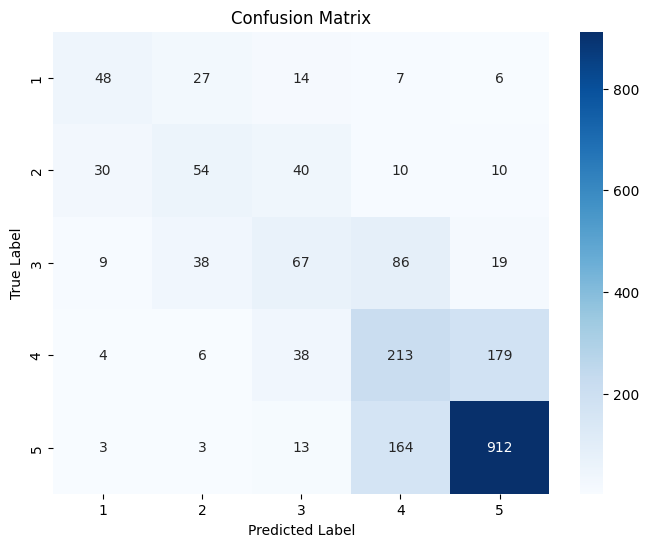